In [14]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMParallelScheduler, UNet2DModel
from matplotlib import pyplot as plt

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


Input shape: torch.Size([8, 1, 28, 28])
Label: tensor([0, 9, 1, 7, 9, 7, 8, 3])


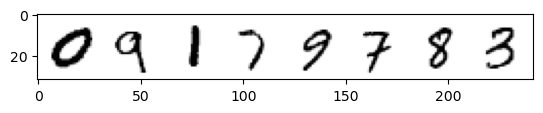

In [13]:
# 加载MNIST数据集
dataset =  torchvision.datasets.MNIST(root='./data/mnist', transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# iter将train_dataloader转换为一个迭代器，next返回迭代器的下一个元素
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Label:", y)

# torchvision.utils.make_grid(x)[0].shape
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [16]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    # print("amount shape:", amount.shape)
    # print("noise shape", noise.shape)
    # print("data shape:", x.shape)

    return x * (1 - amount) + noise * amount

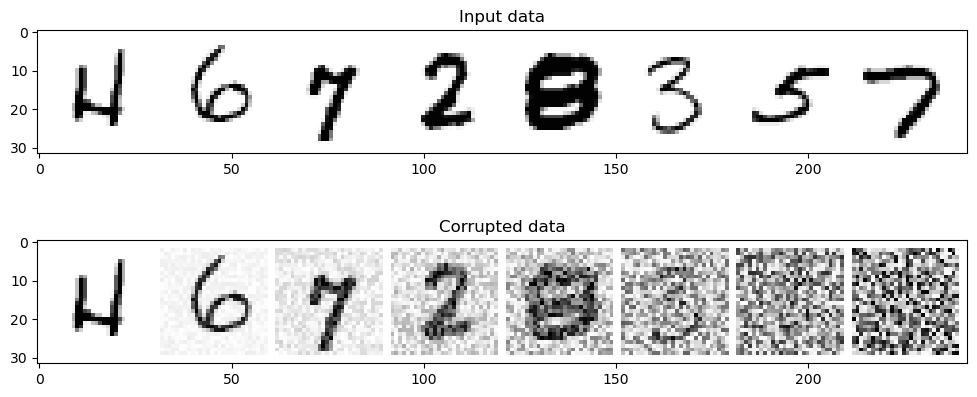

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))

# Input data
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Noise data
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

In [17]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

Training......
Finished epoch 1. Average loss for this epoch: 0.026333
Finished epoch 2. Average loss for this epoch: 0.020386
Finished epoch 3. Average loss for this epoch: 0.018312
Finished epoch 4. Average loss for this epoch: 0.017519
Finished epoch 5. Average loss for this epoch: 0.016984
Finished epoch 6. Average loss for this epoch: 0.016820
Finished epoch 7. Average loss for this epoch: 0.016435
Finished epoch 8. Average loss for this epoch: 0.016174
Finished epoch 9. Average loss for this epoch: 0.016047
Finished epoch 10. Average loss for this epoch: 0.015639


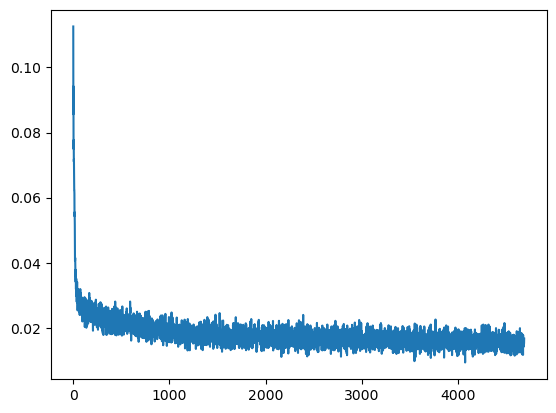

In [18]:
batch_size = 128
n_epochs = 10
losses = []

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net = BasicUNet()
net.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Train
print("Training......")
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noise_x = corrupt(x, noise_amount)

        pred = net(noise_x)
        loss = loss_fn(pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    # 只计算最后len(train_dataloader)的梯度，因为每轮epoch没有对losses进行重置
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    
    print(f'Finished epoch {epoch + 1}. Average loss for this epoch: {avg_loss:05f}')

plt.plot(losses)


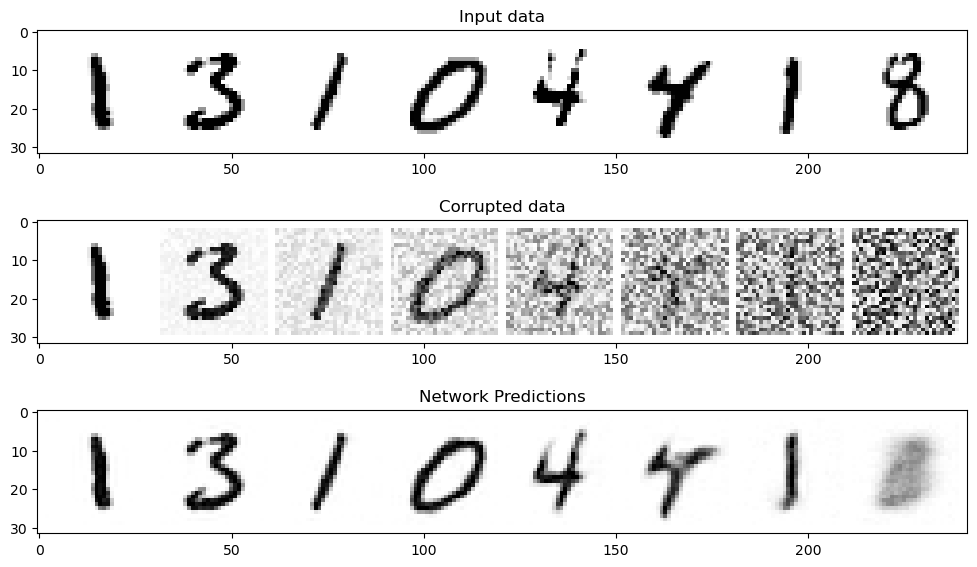

In [19]:
x, y = next(iter(train_dataloader))
# 只用前八张图片
x = x[:8] 


amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()


fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');